In [1]:
import cv2
import rasterio
import numpy as np
import geopandas as gpd
import rasterio.features
import matplotlib.pyplot as plt

In [36]:
img_path = '/home/quyet/DATA_ML/Projects/kuwait_road/test/20220404_132910_ssc17_u0001_visual_clip_0_0015.tif'
with rasterio.open(img_path) as src:
    height = src.height
    width = src.width
    tr = src.transform
    crs = src.crs
    out_meta = src.meta
    projstr = src.crs.to_string()

shp = gpd.read_file('/home/quyet/DATA_ML/Projects/kuwait_road/test/test.shp')
shp = shp.to_crs(projstr)
# ls_geo = [(x.geometry) for i, x in shp.iterrows()]
road_mask = rasterio.features.geometry_mask(shp['geometry']
                                ,out_shape=(height, width)
                                ,transform=tr)[np.newaxis,...]

num_band = 1
dtype="uint8"
path_out = '/home/quyet/DATA_ML/Projects/kuwait_road/test/test.tif'
out_meta.update({"count": 1, "dtype": 'uint8', 'nodata': 0})
new_dataset = rasterio.open(path_out, 'w', compress='lzw', **out_meta)
new_dataset.write(road_mask)
new_dataset.close()

In [59]:
import numpy as np
from PIL import Image
from scipy.ndimage import generic_filter
from skimage.morphology import medial_axis

# Line ends filter
def lineEnds(P):
    """Central pixel and just one other must be set to be a line end"""
    return 255 * ((P[4]==255) and np.sum(P)==510)

# Open image and make into Numpy array
# im = Image.open('lines.png').convert('L')
# im = np.array(im)
im = rasterio.open('/home/quyet/DATA_ML/Projects/kuwait_road/test/test.tif').read()[0]
im = 1 - im
# Skeletonize
skel = (medial_axis(im)*255).astype(np.uint8)

# Find line ends
result = generic_filter(skel, lineEnds, (3, 3))

# Save result
# Image.fromarray(result).save('result.png')

print(np.unique(result))
location = np.where(result == 255)

In [1]:
from contextlib import contextmanager  

import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_raster(raster, outpath, scale=2):
    t = raster.transform

    # rescale the metadata
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    height = int(raster.height * scale)
    width = int(raster.width * scale)

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.bilinear,
        )
    
    num_band = raster.read().shape[0]
    new_dataset = rasterio.open(outpath, 'w', **profile)
    new_dataset.write(data)
    new_dataset.close()
    
    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(data)
            del data
        
        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return     

inpath = '/home/quyet/DATA_ML/Projects/test_building_footprint/img/Nunukan_3B_1m.tif'
outpath = '/home/quyet/DATA_ML/Projects/test_building_footprint/img/Nunukan_3B_%s.tif'%('0.3m')
with rasterio.open(inpath) as src:
    tr = src.transform
    scale = tr[0] / 0.3
    with resample_raster(src, outpath, scale) as resampled:
        print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))
        # print(repr(resampled))

Orig dims: (42978, 91582), New dims: (21488, 45790)


In [3]:
with rasterio.open('/home/quyet/DATA_ML/Projects/road_multi/crop/20220404_132910_ssc17_u0001_visual_clip_0.tif') as src:
    img = src.read()
    tr = src.transform
    crs = src.crs

In [2]:
scale = tr[0] / 0.3

NameError: name 'tr' is not defined

In [7]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rasterio.open('rasterio/tests/data/RGB.byte.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('/tmp/RGB.byte.wgs84.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

AttributeError: module 'rasterio' has no attribute 'calculate_default_transform'

In [31]:
with rasterio.open('/home/quyet/DATA_ML/Projects/road_multi/crop/20220404_132910_ssc17_u0001_visual_clip_0.tif') as src:
    img = src.read()

In [19]:
import gdal
import rasterio
from gdalconst import GA_ReadOnly

data = gdal.Open('/home/quyet/DATA_ML/Projects/road_multi/crop/img_crop/test_0001.tif', GA_ReadOnly)
geoTransform = data.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * data.RasterXSize
miny = maxy + geoTransform[5] * data.RasterYSize
print(minx, miny, maxx, maxy)
print(geoTransform)
# data = None

781873.0 3242864.2 781949.8 3242941.0
(781873.0, 0.3, 0.0, 3242941.0, 0.0, -0.3)


In [16]:
data.RasterXSize * 0.3

76.8

In [195]:
data = gdal.Open('/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006-003-001/img_tif/DJI_0006-003-001_1_0m:1s.tif', GA_ReadOnly)
geoTransform = data.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * data.RasterXSize
miny = maxy + geoTransform[5] * data.RasterYSize
print(minx, miny, maxx, maxy)
print(geoTransform, data.RasterXSize)

805359.0 902373.0 816879.0 908853.0
(805359.0, 3.0, 0.0, 908853.0, 0.0, -3.0) 3840


In [11]:
781873.0 - 781949.8

-76.80000000004657

In [10]:
781949.8 - 782026.6000000001

-76.80000000004657

In [7]:
38.4/0.3

128.0

In [196]:
with rasterio.open('/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006-003-001/img_tif/DJI_0006-003-001_1_0m:1s.tif') as src:
    meta = src.profile

In [197]:
meta

ERROR 1: PROJ: proj_identify: /home/nghipham/anaconda3/envs/onnx/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 3840, 'height': 2160, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]'), 'transform': Affine(3.0, 0.0, 805359.0,
       0.0, -3.0, 908853.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [41]:
# import os
# import glob

# from multiprocessing.pool import Pool
# from functools import partial
# import multiprocessing

# core = multiprocessing.cpu_count()

# num_band = 3
# folder_img = glob.glob('/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006-003-001/img_per_second/*.jpg')
# out_path = '/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006-003-001/aaa'
# with rasterio.open('/home/quyet/DATA_ML/Projects/video_hold/DJI_0007/abc/mask_tif/DJI_0007_0_0m:0s_result.tif') as src_base:
#     height = src_base.height
#     width = src_base.width
#     crs = src_base.crs
#     tr = src_base.transform
#     meta = src_base.profile

# def convert_jpg_to_tif(path, out_path, num_band, meta):
#     img_rgb = rasterio.open(path).read()
#     c,h,w = img_rgb.shape
#     crop_img = img_rgb[..., :, int(w/4):int(w-w/4)]
#     # crop_img = img_rgb
#     c,h,w = crop_img.shape
#     try :
#         meta = rasterio.open(out_path).profile
#     except:
#         meta = meta
#     meta['height']= h
#     meta['width']= w
#     meta['count']= c
#     meta['dtype']='uint8'
#     tr = meta['transform']
#     new_tr = rasterio.Affine(tr[0], tr[1], tr[2]+300,
#                              tr[3], tr[4], tr[5]+300)
    
#     meta.update(transform=new_tr)
#     outpath = os.path.join(out_path, os.path.basename(path).replace('.jpg', '.tif'))
#     new_dataset = rasterio.open(outpath, 'w', **meta)
#     for i in range(num_band):
#         new_dataset.write(crop_img[i],i+1)
#     new_dataset.close()


# if not os.path.exists(out_path):
#     os.mkdir(out_path)
    
# p_cnt = Pool(processes=int(core/2))
# result = p_cnt.map(partial(convert_jpg_to_tif, out_path=out_path, num_band=num_band, meta=meta), folder_img)
# p_cnt.close()
# p_cnt.join()

In [316]:
first_img = '/home/quyet/DATA_ML/Projects/video_hold/DJI_0007/abc/mask_tif/DJI_0007_0_0m:0s_result.tif'
frist_meta = rasterio.open(first_img).profile
list_img_idx = []
folder_path = '/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006-003-001/img_per_second'
out_folder = '/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006-003-001/aaa'
list_img_path = glob.glob(os.path.join(folder_path, '*.jpg'))
for img_path in list_img_path:
    idx = int(os.path.basename(img_path).split('.')[0].split('_')[-2])
    list_img_idx.append([idx, os.path.basename(img_path)])
    # break

total_y = []
    
for n,i in enumerate(sorted(list_img_idx)):
    name_img = i[-1]
    img_path = os.path.join(folder_path, name_img)
    img_rgb = rasterio.open(img_path).read()
    c,h,w = img_rgb.shape
    # crop_img = img_rgb[..., :, int(w/4):int(w-w/4)]
    crop_img = img_rgb
    c,h,w = crop_img.shape
    aaa_df = new_df.to_crs(32617)
          
    if i[0] == 1:
        meta = frist_meta
        old_x = aaa_df.geometry[0].x
        old_y = aaa_df.geometry[0].y     
    else:
        meta = rasterio.open(outpath).profile
    # print(meta['transform'], '\n')
    meta['height']= h
    meta['width']= w
    meta['count']= c
    meta['dtype']='uint8'
    tr = meta['transform']
    
    
    new_x = aaa_df.geometry[n].x
    new_y = aaa_df.geometry[n].y
    dis_x = abs(new_x - old_x)
    
    xxx = dis_x - 1.0995981250090254
    if xxx < 0:
        xxx = 0
    var_x = 42 + 6.420672465480238 * (xxx)
    if i[0] == 1:
        var_x = 0 
    dis_x_pix = dis_x*var_x*3
    
    dis_y = abs(new_y - old_y) 
    
    yyy = dis_y - 1.0995981250090254
    if yyy < 0:
        yyy = 0
    var_y = 42 + 6.420672465480238 * (yyy)
    if i[0] == 1:
        var_y = 0 
    dis_y_pix = dis_y*var_y*3
    
    print(var_x, var_y)
    print("@",dis_x, dis_y)
    print(dis_x_pix, dis_y_pix)
    
    meta.update(transform=rasterio.Affine(tr[0], tr[1], tr[2],
                                          tr[3], tr[4], tr[5]+dis_y_pix))
    
    outpath = os.path.join(out_folder, os.path.basename(img_path).replace('.jpg', '.tif'))
    new_dataset = rasterio.open(outpath, 'w', **meta)
    for i in range(num_band):
        new_dataset.write(crop_img[i],i+1)
    new_dataset.close()
    
    total_y.append([dis_y, outpath])
    old_x = aaa_df.geometry[n].x
    old_y = aaa_df.geometry[n].y


0 0
@ 0.0 0.0
0.0 0.0


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 42.0
@ 0.43949680775403976 1.0090652033686638
55.37659777700901 127.14221562445164


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


44.64583674162625 59.51174534014994
@ 1.5116790644824505 3.826998632401228
202.47053015585334 683.2541040856919


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.05205738742905 81.10799268546843
@ 2.9766690162941813 7.190547771751881
482.6852534763452 1749.6326882272888


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.695794156249534 94.06572783682242
@ 3.8556636697612703 9.208675190806389
690.5007142973955 2598.6622027082776


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.99558171152202 97.0413572269976
@ 3.9023546599783003 9.672120321542025
702.3721136102006 2815.7870497957874


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.995589733312656 97.04133809190252
@ 3.902355909347534 9.672117341309786
702.3724323917487 2815.785626947789


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.93622056535432 99.20094118703372
@ 4.048856270033866 10.008468884974718
740.1659961246044 2978.548599691902


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.6675830551066 102.03234089833998
@ 4.3185106557793915 10.449450686573982
811.8918755862535 3198.545743958728


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.101699964551706 103.59225312756044
@ 4.230376103892922 10.692402221262455
788.1406426235025 3322.9501123401296


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.83306449637742 106.42364798333632
@ 4.500030807685107 11.133383266627789
861.7522703479465 3554.565784893489


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.267185774005945 107.9835572705359
@ 4.411896936129779 11.376334343105555
837.384909221671 3685.371153202509


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


64.84865810086103 109.32712589036997
@ 4.658206389751285 11.585591025650501
906.2353005966818 3799.858105726899


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


65.07351231585967 111.55882964104642
@ 4.693226742558181 11.933172024786472
916.2142446989453 3993.752114971365


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


64.92363007309794 110.07098077785467
@ 4.669883043970913 11.701444137841463
909.5572776942003 3863.9682983084635


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


65.07353853392979 111.55877297724612
@ 4.69323082594201 11.933163199573755
916.2154110016936 3993.7471328450297


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


65.78933211244068 111.48663003314077
@ 4.804713475517929 11.921927157789469
948.2966716379044 3987.4064469675836


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


64.77376988353326 108.58307733180423
@ 4.646542780101299 11.469707749783993
902.9222783768234 3736.248490703969


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.11737597850808 106.49555193010417
@ 4.388564520981163 11.144582085311413
830.9840306301278 3560.5452606167705


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.967489095485774 105.00770859217114
@ 4.365220099687576 10.912855058908463
824.6008470794184 3437.8017118033813


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.96749965566637 105.00768438627587
@ 4.365221744403243 10.91285128891468
824.6012960628557 3437.79973170215


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.53595542703446 105.15189129438164
@ 4.142263131216168 10.935311071574688
764.694358228699 3449.6059232054085


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.326695094576294 105.82366093007265
@ 4.2654184037819505 11.039937127381563
797.5482969099357 3504.859689772041


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.61093099009154 105.89575283131188
@ 4.153940344695002 11.051165219396353
767.7843957418825 3510.81438171356


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.53599363443758 105.15182090115064
@ 4.142269081901759 10.93530010804534
764.6959315681027 3449.60015538455


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.326732464819 105.82358931697934
@ 4.2654242240823805 11.03992597386241
797.5498633900222 3504.853777043606


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.461067598388304 104.40786598495643
@ 4.13059958210215 10.81943141669035
761.613180412364 3388.9012361617


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.87962849484204 103.06426134330587
@ 3.8842953029088676 10.610169123858213
697.7704791073288 3280.587730433993


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.65478636186202 100.83251709798446
@ 3.8492768318392336 10.262581817805767
688.8833611531037 3104.405869840093


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


58.78912069115936 99.41679921946366
@ 3.7144520645961165 10.042088109999895
655.1081121812015 2995.0567721280686


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.57985707583644 100.08856969231508
@ 3.837606825865805 10.14671429619193
685.9321985950171 3046.7103629472476


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.80472578267974 102.32027117069897
@ 3.8726294357329607 10.494294941425323
694.8046243858305 3221.3373124558007


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.38618722943937 103.66382802244958
@ 4.118937194813043 10.703549791127443
758.5375494812857 3328.7128343314844


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.89528716462864 105.96764417283586
@ 4.04248101869598 11.06236207485199
738.5041274731567 3516.757344176969


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.62665624103943 108.79901056515783
@ 4.312136430293322 11.503338687121868
810.1640576533282 3754.6556020642824


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.701624452034196 109.54289145245296
@ 4.32381249871105 11.619195848703384
813.3302024855755 3818.400928857921


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.70163957772888 109.542865548318
@ 4.323814854491502 11.619191814213991
813.3308418214692 3818.3987000536813


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.62670032650456 108.79893357031901
@ 4.312143296469003 11.503326695412397
810.1659179787293 3754.649030915552


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.34248300997069 108.7267885213532
@ 4.423624249175191 11.492090325802565
840.6100315376218 3748.4942235654735


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.70168373495063 109.54278795550746
@ 4.323821731843054 11.619179729372263
813.332708268989 3818.3920239346694


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.910976585110994 108.87097658139032
@ 4.200671523809433 11.514547172933817
780.2030290569248 3760.799986829375


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.70171422552869 109.54273662561492
@ 4.323826480656862 11.619171734899282
813.33399705276 3818.3876074915834


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.77668519616295 110.28661588642697
@ 4.335502978879958 11.735028643161058
816.5055170165216 3882.6497891535655


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.70174475497491 109.54268464991293
@ 4.323831235524267 11.619163639843464
813.3352874802911 3818.3831354853214


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.492481002118495 110.21444249360158
@ 4.446985975373536 11.723787859082222
847.0505176742749 3876.3922284060063


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.77673145824515 110.2865370259164
@ 4.335510184057057 11.735016360878944
816.5074756771106 3882.6429491514314


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


64.28323130159752 110.88617211302501
@ 4.570142903830856 11.828407682478428
881.3506601049405 3934.820550306991


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.56748237363506 110.95826626263792
@ 4.458667208440602 11.839636124670506
850.2787475473577 3941.1164927218097


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.64245519798166 111.70214313156309
@ 4.470343995373696 11.955492660403252
853.5110023354104 4006.3624570821485


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.64247098443509 111.70211562486392
@ 4.470346454065293 11.955488376319408
853.5116834796681 4006.360034890042


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.56752847725476 110.9581844361876
@ 4.458674388937652 11.839623380452394
850.280733568802 3941.1093441097064


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.77682445779709 110.28637664990079
@ 4.335524668451399 11.734991382807493
816.5114131314672 3882.629038882942


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.56755907546773 110.9581306187327
@ 4.458679154515266 11.839614998549223
850.2820516596171 3941.1046424535944


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.62693717114387 108.79851745375771
@ 4.312180184293538 11.503261886537075
810.175912417209 3754.6135174126493


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.70191119741363 109.54239487281686
@ 4.32385715842247 11.619118507951498
813.3423227331208 3818.3582030162333


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.70192631413874 109.54236894476304
@ 4.323859512805939 11.619114469736814
813.3429616939375 3818.355972166035


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.85186167472847 111.03014820404643
@ 4.347211484331638 11.850831516087055
819.6910046520094 3947.39873871699


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.567635104582216 110.95799719928227
@ 4.458690995816141 11.839594218879938
850.2853267983804 3941.0929865373564


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.62701153490711 108.79838812443386
@ 4.312191766221076 11.503241743892431
810.1790504515764 3754.6024798235944


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.76134797803448 107.38268340129092
@ 4.177367328200489 11.282750084996223
773.9995115671877 3634.7159408191133


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.5520791812866 108.05443581539636
@ 4.300521282479167 11.387373458594084
807.0196433473352 3691.368643462807


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.55209310206827 108.0544106766652
@ 4.300523450598121 11.38736954331398
807.0202298083245 3691.366515480595


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.76139078683 107.38260961158053
@ 4.177373995538801 11.282738592475653
774.00128340364 3634.70974087598


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.76140526671523 107.38258528609092
@ 4.177376250736415 11.28273480385542
774.0018827198495 3634.7076970060525


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.552135354750085 108.0543360497944
@ 4.300530031323433 11.387357920408249
807.022009849533 3691.3601983532426


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.70207489516215 109.54211272583996
@ 4.3238826538436115 11.619074564427137
813.3492419975838 3818.3339271192517


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.552163764386556 108.05428531787358
@ 4.300534456036985 11.387350019067526
807.0232067052377 3691.3559039244465


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.70210450074206 109.54206132419081
@ 4.323887264821678 11.619066558778286
813.35049338483 3818.3295045346376


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.98636871619802 109.61416243419455
@ 4.212413616478443 11.63029608502984
783.3366708484978 3824.5354926667133


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.492849603846835 110.2137826916045
@ 4.447043383959681 11.723685096949339
847.0663702786023 3876.3350448599294


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.64279278291683 111.70155589941407
@ 4.470396573189646 11.955401200801134
853.5255682949103 4006.31074659363


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.71777321645357 112.44542824767302
@ 4.4820745452307165 12.071257032454014
856.7634282367502 4072.0729995060783


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.717789603868596 112.44540031043421
@ 4.482077097520232 12.071252681314945
856.7641364643366 4072.0705199965837


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.64284075220829 111.70147299661465
@ 4.47040404425934 11.95538828894496
853.527638060475 4006.3034463648855


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.85214362138484 111.02967480179424
@ 4.347255396656692 11.850757785141468
819.7029616485202 3947.3573491172656


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.62726227640921 108.79795095926798
@ 4.312230818439275 11.503173656761646
810.1896313884338 3754.5651701528905


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.83656442502985 108.12615565863071
@ 4.189082058612257 11.39854360371828
777.1153277973406 3697.442099931997


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.55232510612649 108.05400164008907
@ 4.300559584517032 11.387305837124586
807.0300038069329 3691.3318908025676


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.552338999999435 108.05397647743905
@ 4.300561748445034 11.387301918119192
807.0305891374923 3691.3297608058438


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.686674280071806 106.6382844312966
@ 4.165737129282206 11.166812233626842
770.9114082912986 3572.4290974811456


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.47739945277911 107.31002859339227
@ 4.2888901443220675 11.27143432199955
803.8761082676917 3628.613818146944


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.836636997867785 108.12603206983538
@ 4.189093361608684 11.398524355143309
777.1183366559217 3697.431629919075


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.477426950508715 107.30997903349603
@ 4.288894427008927 11.271426603198051
803.8772647856825 3628.609657400317


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.70234496610014 109.54164716897677
@ 4.323924716562033 11.619002055376768
813.360657555958 3818.293870817093


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.552422964198655 108.05382633869931
@ 4.3005748256109655 11.387278534471989
807.034126442406 3691.317051702704


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.82107932849474 105.2224746564817
@ 4.030923376325518 10.946304213255644
735.4953313157346 3455.3916529842923


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.67115489882807 103.73465767714211
@ 4.007573107257485 10.714581292122602
729.4322662763898 3334.4202674767475


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.46459553304629 106.11058988682517
@ 3.819655194878578 11.08462543040514
681.4027537174613 3528.588429284378


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.379465328257204 105.87159525215556
@ 3.027661796659231 11.047402750700712
493.9278890913588 3508.8184578292075


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


52.0073611272326 103.8562840010334
@ 2.6582138589583337 10.733524218201637
414.7400643487818 3344.2318186125576


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


53.363892183376024 102.96810658163092
@ 2.869489401113242 10.595193315297365
459.3813690670419 3272.9009836275677


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


53.513855236036164 104.45588289889346
@ 2.892845685593784 10.8269099034369
464.42197571717264 3392.803299090824


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.30458680405103 105.12762902233638
@ 3.0159996966831386 10.931532297283411
491.3478519885632 3447.618215983497


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.39520322331714 108.77495842037536
@ 3.185859851539135 11.499592639505863
529.444061751052 3752.603133640514


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.05435010659902 112.5665522513997
@ 3.132773026358336 12.09012172371149
517.4183489929247 4082.8299562138563


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.488587812311515 114.12645732887836
@ 3.044657288119197 12.333072144538164
497.6972280062313 4222.589495512839


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


51.70065065302404 115.15887002416507
@ 2.610444645397365 12.493867248296738
404.8850599822392 4316.33890363733


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


49.628456160935116 116.11915166302424
@ 2.287706722971052 12.643428161740303
340.60605843013616 4404.432456761022


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


50.34423184514225 116.04700015596384
@ 2.3991865855641663 12.63219078630209
362.3556171101928 4397.783538444491


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


48.98777825324543 116.93514939893882
@ 2.187923108227551 12.77051730081439
321.5444761830083 4479.96704541739


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


45.48412937478584 118.03970821954044
@ 1.6422405652701855 12.94254894182086
224.08764700581162 4583.204102128969


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


43.41195529147175 119.0
@ 1.3195058214478195 13.092111434787512
171.84698318258833 4673.883782219142


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.546326273445736 117.58433653690582
@ 1.1846867627464235 12.871626202017069
151.2122086189246 4540.50488134569


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 117.05684401120065
@ 0.8385986965149641 12.789470862597227
105.66343576088548 4491.285287246518


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 116.74576828662053
@ 0.158092244528234 12.741021774709225
19.919622810557485 4462.381127534969


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 114.73049657338858
@ 0.21134925074875355 12.427149400115013
26.630005594342947 4277.31906500065


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 115.69080894799421
@ 0.5340809812769294 12.576715100556612
67.2942036408931 4365.031031675547


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 114.49157955544837
@ 1.0033172406256199 12.389938808977604
126.4179723188281 4255.630994505589


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


43.52893642154036 114.70800635466058
@ 1.3377252728678286 12.423646617680788
174.6892750564543 4275.275205506956


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


43.60384849494995 113.96412271669553
@ 1.349392598029226 12.307789027690887
176.51613121401982 4207.939137368889


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


45.11021972654454 113.36451996789759
@ 1.5840052869170904 12.214402742683887
214.36447962251455 4154.039710856792


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


46.76655015986139 111.27713018618388
@ 1.8419736605137587 11.8892982006073
258.42826076268057 3969.020951074021


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


47.63217469309949 109.86149676518897
@ 1.9767920207232237 11.668817646801472
282.47670858904127 3845.8613164729795


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


49.77929492823156 110.07793834626213
@ 2.31119939731434 11.70252775773406
345.14962931058466 3864.570387033813


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


53.50782999822758 108.9508790218189
@ 2.891907273326069 11.526991732418537
464.2190482553075 3767.6276451727163


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.87989159675692 106.93564612891109
@ 3.2613485758192837 11.21312540397048
546.7314146280575 3597.2484305942708


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


58.7427344281667 107.22424624919208
@ 3.707227546721697 11.25807398557663
653.3180497255697 3621.4154919632756


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.308427522176785 108.78421133911267
@ 3.7953325072303414 11.501033753156662
675.2856087828966 3753.3926592649877


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


58.81758326905664 106.48041279301387
@ 3.718885023612529 11.142224211245775
656.2074886331328 3559.2859003372905


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.38327464389802 108.04037912671564
@ 3.8069897163659334 11.385184172540903
678.214547680361 3690.178843286404


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.30822095882543 108.78430656012955
@ 3.795300335623324 11.50104858353734
675.2775327307572 3753.400784623409


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.30815124130247 108.78433856357606
@ 3.7952894773334265 11.50105356797576
675.2748069786439 3753.4035155294987


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.15810883480508 110.27216202492909
@ 3.771920833736658 11.732777498662472
669.4191095953857 3881.3962240048513


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.948748416830085 109.60044577615335
@ 3.8950605182908475 11.628159757703543
700.5120092380374 3823.354479001907


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.94867692333111 109.60047907121877
@ 3.8950493833981454 11.628164943307638
700.5091712572663 3823.357345517006


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.17356980916095 107.36882442598008
@ 3.9300757590681314 11.28059159219265
709.4600641307322 3633.551574249959


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.52996121199877 108.25705097473917
@ 4.141329550649971 11.418930146843195
764.4475398527909 3708.5391089513687


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.81416727769471 108.18493666151981
@ 4.029846845660359 11.407698564231396
735.2153405264382 3702.4234398752524


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.45483109717064 109.00101689361304
@ 4.129628266207874 11.534800551831722
761.3568227817195 3771.9149694440002


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.37976903152438 109.74494860850447
@ 4.117937580216676 11.650665629655123
758.274172679802 3835.805102344113


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.73615100434816 110.63318273954499
@ 4.329189903102815 11.789005365222692
814.7901344626728 3912.7655546644755


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.02035332973098 110.56106904821624
@ 4.217706615570933 11.777773879468441
784.7509636165591 3906.489813366564


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.52953394027501 108.25726363740206
@ 4.1412630043923855 11.418963268399239
764.4299477530997 3708.55715103872


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.81374165039318 108.18514599945995
@ 4.029780555516481 11.407731167972088
735.1981008328717 3702.4411857889504


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.5293938175616 108.25733333698588
@ 4.1412411807104945 11.418974123895168
764.4241785043193 3708.5630642908063


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.96359066087653 106.69742072506354
@ 4.053119078278542 11.17602252960205
741.2780771638865 3577.3583336212164


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.038518305469736 105.95355727462379
@ 4.064788828603923 11.060168083757162
744.3260619678283 3515.5924575879917


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.24773570953804 106.62533293786974
@ 3.941626870073378 11.164795078337193
712.4222818013836 3571.349977232378


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.963389799185535 106.69752096904287
@ 4.053087794687599 11.176038142293692
741.2699133535841 3577.3666921146123


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.3225986984389 105.88150129952555
@ 3.953286550473422 11.0489455871284
715.4175543724322 3509.6368396257685


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.39753043016883 105.13763622260274
@ 3.9649569373577833 10.933090887963772
718.4208218351271 3448.437997702163


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.11318604165435 105.20982549755703
@ 4.076418098993599 10.944334145635366
747.3686930020884 3454.354456947756


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.32240302116274 105.88159876891609
@ 3.9532560743391514 11.048960767686367
715.4097184864379 3509.6448924529896


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.03805695533759 105.95378928765159
@ 4.064716974738985 11.060204219073057
744.3072786343371 3515.6116419181853


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.978708988466614 103.79428796730733
@ 4.211220637429506 10.723868526518345
783.0180551204046 3339.228893894966


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.33508371686299 104.68253821966543
@ 4.422471832018346 10.862210772931576
840.292871149051 3411.2513831624137


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.05358269601058 103.05045896003871
@ 4.222881987225264 10.608019445091486
786.1348698293293 3279.4838174210786


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.76923936889591 103.12265289917244
@ 4.334343314170837 10.619263429194689
816.1902989824887 3285.2598499611586


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.69417506384555 103.86658595352053
@ 4.322652279399335 10.735128715634346
813.0153562343787 3345.063508393623


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.1283986305167 102.30666291297138
@ 4.234534339047968 10.492175497114658
789.2545122929512 3220.2583854211416


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.33476413984621 104.68271545848359
@ 4.422422058880329 10.862238377332687
840.2791740781161 3411.2658278896142


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.25969521247445 105.42665028282796
@ 4.410730304196477 10.978103939443827
837.0643641236816 3472.154174376841


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.54391151245639 105.35452384274211
@ 4.299249193165451 10.966870468109846
806.6755833220186 3466.228248638229


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.97527978790936 105.49888622349539
@ 4.522180402185768 10.989354465156794
867.9232694437048 3478.0939691677127


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.61878482234916 104.61069686857735
@ 4.310910481028259 10.851021703332663
809.8319273997547 3405.398826365061


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.7687324832172 103.12293406547572
@ 4.334264368284494 10.619307219982147
816.1688419331695 3285.2823548017477


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


62.052953785232596 103.0508037505331
@ 4.222784036304802 10.608073145151138
786.1086679495195 3279.511391556811


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.48719046243373 101.49087351040444
@ 4.1346681378781796 10.36511880531907
762.6873818780156 3155.894884772857


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.48713139478711 101.49090572912075
@ 4.1346589382737875 10.365123823285103
762.6849522308141 3155.897414459076


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.35567471786047 98.37100719394306
@ 3.9584380388259888 9.879209216684103
716.7425959865607 2915.4832827747014


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.78992346512079 96.81107061531414
@ 3.8703240202739835 9.636253889650106
694.2191308722003 2798.688167334036


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.430578099751095 97.62716584453813
@ 3.970104010310024 9.76335821300745
719.7470413775247 2859.5069743827353


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.78982044655268 96.81112739870878
@ 3.870307975448668 9.636262733489275
694.21505677481 2798.69237741778


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.43047358326382 97.62722382387621
@ 3.9700877321884036 9.763367243111134
719.7428454697533 2859.511317353735


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.789717424994706 96.8111841821034
@ 3.8702919301576912 9.636271577328444
694.2109825690972 2798.696587504536


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.43036902790838 97.62728173145769
@ 3.9700714480131865 9.763376262038946
719.7386480117983 2859.5156549529074


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.355304250460364 98.37121112621884
@ 3.958380339667201 9.879240978509188
716.7277492189637 2915.4987001911604


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.28023781663068 99.11514068841208
@ 3.9466889733448625 9.995105721056461
713.7220497045068 2971.998929214191


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.99589667211279 99.18734134874795
@ 4.058150640223175 10.006350751966238
742.5916113927635 2977.5099830717277


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.99584144942435 99.18737203665668
@ 4.058142039459199 10.006355531513691
742.5893652542906 2977.512326505918


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


60.28007289005028 99.11523062335894
@ 3.946663286536932 9.995119728147984
713.7154517547949 2972.0057908904164


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.639319963818316 98.29918729808034
@ 3.846867987886071 9.868023488670588
688.2737723643221 2910.056067524059


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


58.848538432276285 98.97094339569156
@ 3.7237061951309443 9.972647435963154
657.404001404006 2961.0069746696936


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


57.151442595398954 94.29104649944671
@ 3.4593887352384627 9.243767879903316
593.1271701514523 2614.813640982167


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


53.11662278613081 84.11514322208717
@ 2.8309779525734484 7.65890222415328
451.1159640680903 1932.6889725258452


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


53.191607838999104 83.3712585316919
@ 2.8426566440612078 7.5430444702506065
453.6164322954871 1886.6193319359365


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


53.68223743522066 85.67515184434907
@ 2.919070695526898 7.901868771761656
470.1067385024089 2030.9814206243998


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.322897918014384 86.49124492087486
@ 3.0188515963964164 8.028972759842873
491.9783013020319 2083.3075483038074


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.81352038641302 88.79514153433593
@ 3.0952645377255976 8.387797575443983
508.9870375198899 2234.3870186187246


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.88850086479764 88.05125976204265
@ 3.1069425167515874 8.271940276026726
511.60625105278825 2185.0642859415957


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.24777141493546 87.23520155922763
@ 3.0071508744731545 8.144841719418764
489.39369974592887 2131.5507271845063


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.24773556653078 87.23521980932456
@ 3.0071452911943197 8.144844561815262
489.39246770054297 2131.551916988208


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.39773937694343 85.74743531180889
@ 3.0305079235695302 7.913126699626446
494.5583406182919 2035.5909593710994


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


51.34429323881453 80.17925687732546
@ 2.554943073540926 7.045900024473667
393.54523912909013 1694.8050839826838


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


50.92863823095615 77.13148669574312
@ 2.4902060837484896 6.571219187229872
380.4684142792588 1520.5437159438984


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


50.853593835374255 77.87540049540178
@ 2.4785181498155 6.687081474810839
378.12466591296214 1562.277443988828


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


51.98490498392313 80.995375714473
@ 2.6547163836658 7.173008024692535
414.0155368923919 1742.9414398887052


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


53.19123218419432 83.37145215493518
@ 2.8425981369800866 7.543074626475573
453.60389253139795 1886.6312559669414


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


53.0411570387452 84.85927159791825
@ 2.819224394392222 7.774797931313515
448.60477149125757 1979.2910678167996


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.88816336656838 88.05143331735499
@ 3.106889952439815 8.271967306733131
511.59444981439924 2185.0757331364584


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.37876659821674 90.35533791971827
@ 3.1832998977042735 8.630793366581202
528.8616661412766 2339.514753458122


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


56.735121467972256 91.24362086917009
@ 3.394547999370843 8.76914070546627
577.7702792195009 2400.3844496339134


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.30366120054971 91.09928180931394
@ 3.1716024628840387 8.746660340577364
526.2036842105038 2390.4434257698213


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


56.01932893890174 91.17148354599891
@ 3.283065513242036 8.757905539125204
551.7453807428096 2395.413722273299


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.37860354627768 90.35542125305732
@ 3.18327450286597 8.630806345492601
528.8558900195662 2339.5204293016322


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


56.659929481010145 91.98761015677883
@ 3.3828370785340667 8.88501475006342
575.0139309464598 2451.9338191981906


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


56.01920410034552 91.1715478877561
@ 3.283046070020646 8.757915560156107
551.7408836019714 2395.4181536690903


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.869109739075135 92.65937419545452
@ 3.259669334627688 8.989639934152365
546.344471308237 2498.9232316230755


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


56.58477410486666 92.73157925686226
@ 3.3711318597197533 9.000885650515556
572.2642042798839 2503.9990232482123


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


56.5097028155066 93.4755044419025
@ 3.359439737163484 9.116749711334705
569.5228235211363 2556.5783344127417


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


56.58468576052458 92.73162458311873
@ 3.371118100360036 9.000892709940672
572.2609751114676 2504.002211073446


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


56.584641800633506 92.7316472582064
@ 3.3711112537421286 9.000896241515875
572.2593682892486 2504.0038058278974


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.86889081265846 92.65948482022293
@ 3.2596352375112474 8.989657163619995
546.3366155208297 2498.9310044743656


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


56.01890589483805 91.17170080108463
@ 3.282999625429511 8.757939375936985
551.7301412091731 2395.428685250894


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.94383447990393 91.91562522072107
@ 3.271307483315468 8.873803317546844
549.0284531384149 2446.923540054081


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.94379196411456 91.91564684337851
@ 3.2713008616119623 8.873806685209274
549.026924562145 2446.925044302321


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.94374940048745 91.91566846603594
@ 3.271294232457876 8.873810052871704
549.0253942676501 2446.926548550997


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.51229480781654 91.77131567674907
@ 3.048349579796195 8.851327549666166
498.5175929134016 2436.893924156159


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


53.72151568012083 92.44305129980857
@ 2.925188161432743 8.955948308110237
471.4366250451388 2483.7455666552055


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


52.29006234319053 92.29869444431401
@ 2.7022437043488026 8.933465171605349
423.901475300679 2473.64151660877


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


52.214988497501366 93.04261537179559
@ 2.6905511836521327 9.049328569322824
421.4612973190044 2525.9195923455145


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


50.78353609938667 92.89825533509146
@ 2.4676068727858365 9.026844937354326
375.94140810964257 2515.7344375818598


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


49.202018216056004 94.24169986383396
@ 2.221290323883295 9.236082293093204
327.8759009365645 2611.2722861500833


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


48.48627159327452 94.16952472493115
@ 2.1098149875178933 9.224841237068176
306.89118748906105 2606.0967448729684


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


46.18904844288661 95.44077550589088
@ 1.7520295432768762 9.422834638506174
242.77373234335238 2697.9679360884006


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


43.96685994114154 95.96811925623183
@ 1.4059305149130523 9.50496680662036
185.44305010847756 2736.521364072803


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.38534129838679 97.31155400215698
@ 1.159613847732544 9.714202638715506
147.45188613143824 2835.912463995779


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 99.47108115487958
@ 1.013079079799354 10.05054235458374
127.64796405471861 2999.2149426100614


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 99.9984169402372
@ 0.6669800626114011 10.132673282176256
84.03948788903654 3039.753862770789


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 100.59794113946987
@ 0.43234980665147305 10.226047333329916
54.476075638085604 3086.157923183267


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 99.85404068654
@ 0.4440301014110446 10.110187124460936
55.94779277779162 3028.629109423365


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 102.01356152468125
@ 0.2974948436021805 10.446525856852531
37.48435029387474 3197.0619246515976


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 100.45356376158583
@ 0.209393709897995 10.203561000525951
26.38360744714737 3074.9521966846924


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 101.94137217797034
@ 0.18601350486278534 10.435282588005066
23.437701612710953 3191.3610782583537


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 101.19747024207061
@ 0.19769401755183935 10.319422148168087
24.90944621153176 3132.8982472638127


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 101.05308336839565
@ 0.025248652324080467 10.296934336423874
3.181330192834139 3121.610891812612


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 99.42088776739087
@ 0.22481665760278702 10.042724888771772
28.326898857951164 2995.369872136084


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 98.60478842412142
@ 0.3246031254529953 9.915619924664497
40.89999380707741 2933.182814296637


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 98.53259147121022
@ 0.43607653491199017 9.904375471174717
54.94564339891076 2927.7113462362013


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 99.20429662163082
@ 0.5592371020466089 10.008991483598948
70.46387485787272 2978.80488006698


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


42.0 99.0599017112159
@ 0.7821781216189265 9.986502420157194
98.55444332398474 2967.785844538774


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


44.181130170290785 97.88281726852628
@ 1.4393024444580078 9.803175136446953
190.77002595905088 2878.687201596592


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


48.400301886594946 96.7057278028742
@ 2.0964254699647427 9.619847070425749
304.40287688712067 2790.8829368936076


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


51.97880970867671 96.34473335117627
@ 2.65376706328243 9.563623294234276
413.8189595805337 2764.214208462298


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


53.560304836193524 97.68813123812453
@ 2.900080068036914 9.772853385657072
465.9875174802779 2864.075352327053


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


54.12593273932656 96.12811383763778
@ 2.98817487526685 9.529885470867157
485.21325693611715 2748.2697462095052


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.066771297774565 98.28760862813085
@ 3.1347075887024403 9.866220146417618
517.8546776174269 2909.181553170224


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


55.632395915052996 96.72759010345726
@ 3.2228018841706216 9.623252056539059
537.8765711278763 2792.5019411614867


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


57.138842219007316 97.3270803857339
@ 3.457426265347749 9.716620825231075
592.6600015786703 2837.0710084048824


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


58.495199483639574 96.43876502621478
@ 3.66867474000901 9.578268438577652
643.7995822722498 2771.149137917998


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


59.135859174120775 95.62264700230878
@ 3.768455517478287 9.451160565018654
668.5525643566032 2711.2349714127595


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.35799161003727 96.14993554790041
@ 4.1145458137616515 9.53328413516283
757.3808025597041 2749.8739654671826


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


61.998645957641145 95.33381599318682
@ 4.2143257590942085 9.406176023185253
783.8474720647473 2690.1799625816057


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


63.430035090347744 95.18939900565596
@ 4.437260216567665 9.383683521300554
844.3667137256732 2679.681584555631


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


65.57711325816922 94.9727821471119
@ 4.771661041304469 9.349946111440659
938.7352696056505 2663.971185387269


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


67.08354008020487 95.57226386643349
@ 5.006282388232648 9.443313546478748
1007.5174357314859 2707.556562112598


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


69.94630130342401 95.28344503201578
@ 5.452148648910224 9.39833090081811
1144.072896443192 2686.5160373423932


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


73.44970149441437 94.1785249408191
@ 5.9977924595586956 9.226242993026972
1321.6081973401067 2606.741867486545


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


75.37162291540433 91.73020222673816
@ 6.297125813085586 8.844924256205559
1423.873776704237 2434.0400721057526


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


77.51867425821439 91.51358075185242
@ 6.63152245990932 8.811186127364635
1542.2004882172296 2419.029579558556


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


79.44058450012304 89.06525959249794
@ 6.930854072328657 8.429867632687092
1651.7732957725395 2252.4250471070154


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


80.79689176235998 88.17693868380127
@ 7.142094759270549 8.29151438176632
1731.1771716639028 2193.361065710595


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


82.00310449290458 85.80082005045443
@ 7.329958684276789 7.921441208571196
1803.2381037462687 2038.9984550306144


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


84.8658243245212 85.51200150306315
@ 7.775818498339504 7.87645860761404
1979.7037399783276 2020.5952208793196


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


85.58147789991301 85.43978134884915
@ 7.8872793428599834 7.86521054059267
2025.0150683142363 2016.0056065527042


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


85.50639823595901 84.69586240663368
@ 7.8755859159864485 7.749347452074289
2020.2389570215419 1969.0129966262439


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


85.43131854808613 83.95194434941635
@ 7.863892485387623 7.633484501391649
2015.4681118411522 1922.5375981588918


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


86.07192369158692 83.13582768888588
@ 7.963664767332375 7.506376840174198
2056.3438384776346 1872.1465546576974


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


85.9968428645779 82.39191135382711
@ 7.951971159316599 7.39051415771246
2051.533242754215 1826.7557620243476


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


84.56544006223777 82.53629174548863
@ 7.729034572839737 7.413000959903002
1960.827629725327 1835.524829808424


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


82.98394931785367 81.19287826343788
@ 7.4827222507447 7.203768439590931
1862.8375320461225 1754.6840818611067


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


79.7459595300665 77.76217493270747
@ 6.978415294550359 6.669446941465139
1669.5012709896303 1555.8920992998687


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


80.53666040419293 78.4338571688517
@ 7.1015645251609385 6.774059385061264
1715.8088715040503 1593.9468187836437


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


80.4615868156316 77.68994566540445
@ 7.089872044511139 6.658197455108166
1711.3870650634576 1551.8249955506626


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


81.25228565067445 78.36162742317131
@ 7.213020957540721 6.762809824198484
1758.2233177392 1589.8343513328132


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


81.32730228840907 79.10550771249473
@ 7.224704568274319 6.878666892647743
1762.6971971054868 1632.4213107840847


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


78.31446104029155 77.90649801475922
@ 6.755463805049658 6.6919248178601265
1587.1515209089835 1564.033282612614


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


72.58899750602723 78.48407677142069
@ 5.863740459084511 6.781880933791399
1276.9291246814296 1596.808991586955


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


71.87330050891887 78.55626119084462
@ 5.752272851765156 6.793123435229063
1240.3045058526384 1600.927136638506


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


77.8988980572912 80.9542309307439
@ 6.6907411478459835 7.166599851101637
1563.6040878113336 1740.4997380029504


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


83.84943841647666 82.60830306405873
@ 7.617519517429173 7.424216501414776
1916.1742009889592 1839.905780286173


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


86.22157707263185 84.62336931420731
@ 7.986972821410745 7.738056875765324
2065.948178094847 1964.4613343166907


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


86.14649603334286 83.87945539495429
@ 7.975279180333018 7.622194569557905
2061.1270688200807 1918.0365882266854


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


86.07141499704375 83.13554248029376
@ 7.9635855397209525 7.506332419812679
2056.3112275613357 1872.12905327563


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


85.28065783583922 82.4638294844842
@ 7.840427542570978 7.401715185493231
2005.9104556340562 1831.1213368476933


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


85.35566938184462 83.20770412895456
@ 7.852110360283405 7.517571374773979
2010.6664075863214 1876.5595641614746


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


85.35563525559849 83.20768518521044
@ 7.852105045225471 7.517568424344063
2010.6642426867302 1876.5584004332977


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


86.86199579545871 83.80716049427517
@ 8.086716068908572 7.610934861004353
2107.2848915298146 1913.5525182229967


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


84.56484609094744 82.53595408281714
@ 7.728942063637078 7.412948369979858
1960.7903881719576 1835.5042988488553


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


82.19265537238437 80.52085738394854
@ 7.3594806510955095 7.099103253334761
1814.6857706256724 1714.8776418470802


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


82.19262540802143 80.52084054506486
@ 7.359475984238088 7.0991006307303905
1814.683958315433 1714.8766497012334


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


83.62394020088365 80.37642559063787
@ 7.582398863509297 7.076608445495367
1902.210207424049 1706.3774764603136


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


84.48967159166833 81.79199194312454
@ 7.717233866453171 7.297078553587198
1956.0796649181875 1790.527770790053


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


83.69892138487491 81.1202822959566
@ 7.594076952431351 7.192461840808392
1906.8481494967264 1750.3636047878172


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


83.62384352380563 80.376374499934
@ 7.582383806351572 7.0766004882752895
1902.2042308793448 1706.3744730960916


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


83.62381145757209 80.37635773280695
@ 7.582378812134266 7.07659787684679
1902.202248557416 1706.3734874419793


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


82.90810968565955 80.44853987993835
@ 7.470910461153835 7.087840024381876
1858.1971918952506 1710.6191425923257


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


82.83303284712193 79.70463342337241
@ 7.459217474330217 6.971978880465031
1853.608818195062 1667.097062708879


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


83.62371637109885 80.37630762277672
@ 7.582364002708346 7.076590072363615
1902.1963703547376 1706.3705417297572


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


82.83297031123932 79.70460060668435
@ 7.459207734558731 6.971973769366741
1853.6049984662104 1667.0951541829672


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


82.11727166372903 79.7767830886799
@ 7.347739870194346 6.983215969055891
1810.1290531054865 1671.2955168743324


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


82.11724167544722 79.77676679993023
@ 7.347735199611634 6.983213432133198
1810.127241461097 1671.2945684682916


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


81.25145340260256 78.36117258196134
@ 7.21289133746177 6.762738984078169
1758.173713211432 1589.8084699743217


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


80.53575828013555 78.43335597287393
@ 7.101424022112042 6.77398132532835
1715.7557054686904 1593.9182659292362


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


80.46068448527399 77.68945286494963
@ 7.089731509331614 6.6581207029521465
1711.3339501729088 1551.7972635634383


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


79.74499130023537 77.76163668640183
@ 6.9782644957304 6.669363111257553
1669.4449245082865 1555.8617735619014


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


79.74496430181216 77.76162176102767
@ 6.978260290808976 6.669360786676407
1669.4433533379454 1555.860932644082


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


79.6698914666952 77.0177198729657
@ 6.966567927505821 6.5535003542900085
1665.0771320392455 1514.206963422268


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


79.74491028104688 77.76159229298126
@ 6.978251877240837 6.669356197118759
1669.4402096073527 1555.8592723710508


/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


82.04196460607876 79.03275459804513
@ 7.336011027451605 6.867335818707943
1805.5822711919643 1628.2333995069305


In [357]:
total_x = []
total_y = []
total_name = {}
for n,i in enumerate(sorted(list_img_idx)):
    name_img = i[-1]
    img_path = os.path.join(folder_path, name_img)
    outpath = os.path.join(out_folder, os.path.basename(img_path).replace('.jpg', '.tif'))
    aaa_df = new_df.to_crs(32617)
    
    if n == 0:
        old_x = aaa_df.geometry[0].x
        old_y = aaa_df.geometry[0].y  
        pass
    else:   
        new_x = aaa_df.geometry[n].x
        new_y = aaa_df.geometry[n].y
        dis_x = abs(new_x - old_x)
        dis_y = abs(new_y - old_y) 
        total_y.append([n,dis_y])
        total_x.append([n,dis_x])
        total_name.update({n:outpath})
        
        old_x = aaa_df.geometry[n].x
        old_y = aaa_df.geometry[n].y

In [285]:
print(max(total_y.values()))
max(total_y, key=total_y.get)

13.092111434787512


101

In [286]:
print(min(total_y.values()))
min(total_y, key=total_y.get)

1.0090652033686638


1

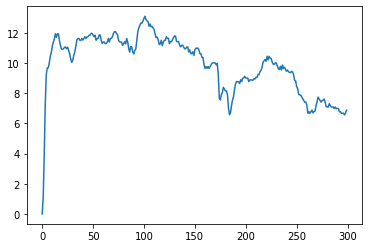

In [344]:
import matplotlib.pyplot as plt

list_points = []
for n,i in enumerate(total_y):
    list_points.append(i[0])
    # print(i[0])

arr = np.array(list_points) 
plt.plot(arr)

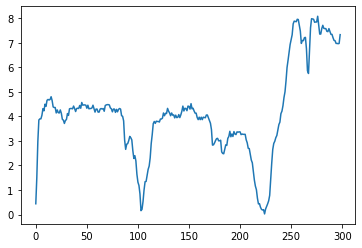

In [358]:
list_points = []
for n,i in enumerate(total_x):
    list_points.append(i[1])
    # print(i[0])

arr = np.array(list_points) 
plt.plot(arr)

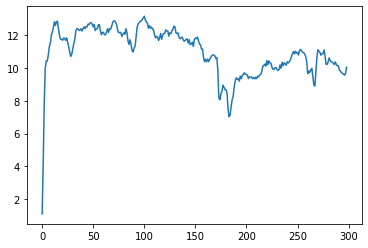

In [359]:
list_points = []
for i,j in zip(total_x, total_y):
    list_points.append(math.sqrt(i[1]**2 + j[1]**2))

arr = np.array(list_points) 
plt.plot(arr)

In [317]:
total_name[101]

'/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006-003-001/aaa/DJI_0006-003-001_102_1m:42s.tif'

In [288]:
aaa_df.geometry[1].y - aaa_df.geometry[0].y

-1.0090652033686638

In [184]:
import json
import numpy as np
from itertools import islice

with open('/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006.SRT') as f:
    lines = f.read().splitlines()
str_list = list(filter(None, lines))

# list of length in which we have to split
length_to_split = list(np.ones(len(str_list)//6)*6)
  
# Using islice
Inputt = iter(str_list)
Output = []
geo_points = []
for n, elem in enumerate(length_to_split):
    # print(elem)
    item_gps = list(islice(Inputt, int(elem)))
    Output.append(item_gps)
    
import pandas as pd
import geopandas as gpd
from shapely import geometry

geo_points = []
for i in Output:
    if int(i[0])%25 == 0:
        infor_gps = i[-2]
        lat_long = infor_gps.split(",")[-1].split("] [")
        latitude = float(lat_long[0].split(" ")[-1])
        longitude = float(lat_long[1].split(" ")[-1])
        altitude = float(lat_long[-1].split("]")[0].split(" ")[-1])
        
        gps_x = longitude
        gps_y = latitude
        geo_points.append([n, geometry.Point(gps_x, gps_y)])

new_df = pd.DataFrame(geo_points, columns=['ID', 'geometry',])

gdf = gpd.GeoDataFrame(new_df, crs=4326)
gdf.to_file('/home/quyet/DATA_ML/Projects/change_detection/new_video/March/trajectory/DJI_0006.shp')

/home/nghipham/anaconda3/envs/onnx/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
[latitude: 17.000956] [longitude: 80.000040] [altitude: 44.300000]
[latitude: 17.000965] [longitude: 80.000043] [altitude: 44.300000]

In [193]:
new_df = gdf.to_crs(3857)
new_df.geometry[1].distance(new_df.geometry[2]) 

4.111392175501509

In [199]:
rasterio.open('/home/quyet/DATA_ML/Projects/change_detection/new_video/March/DJI_0006-003-001/img_tif/DJI_0006-003-001_1_0m:1s.tif').profile

ERROR 1: PROJ: proj_identify: /home/nghipham/anaconda3/envs/onnx/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 3840, 'height': 2160, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]'), 'transform': Affine(3.0, 0.0, 805359.0,
       0.0, -3.0, 908853.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

In [ ]:
9.060905031359606e-05 

In [185]:
import math
distance_meter = 1.0995981250090254
distance_pixel = 126/3
pix_per_meter = distance_meter/ distance_pixel

# distance_point = 

In [194]:
4.111392175501509 / pix_per_meter

157.0378008507845

In [186]:
distance_meter / pix_per_meter

42.0

In [171]:
distance_meter

9.4868

In [164]:
round(24.52)

25

In [176]:
round((0.00171 - 0.00165)*10e4)

6

In [223]:
1/pix_per_meter

38.19577265981175

In [217]:
round((abs(dis_x)/pix_per_meter)/3)

551

In [216]:
round(1651.5144920527446/3)

551

In [ ]:
[latitude: 17.000956] [longitude: 80.000040] [altitude: 44.300000]
[latitude: 17.000965] [longitude: 80.000043] [altitude: 44.300000]

In [241]:
print(new_df.geometry[10].x , new_df.geometry[10].y)

8905563.716241518 1920936.3246767242


In [243]:
print(new_df.geometry[299].x , new_df.geometry[299].y)

8905733.144506505 1923939.8184056834


In [247]:
2917.701993565075/290

10.06104135712095

In [ ]:
8905847.914901514

1923939.8184056834

In [ ]:
119 -> 13.092111434787512

In [295]:
13.092111434787512/119

0.11001774314947489

In [ ]:
42 -> 1.0995981250090254

In [296]:
1.0995981250090254/42

0.026180907738310128

In [318]:
355 -> 13.092111434787512

313

In [ ]:
316 -> 12.94254894182086

In [299]:
13.092111434787512 - 1.0995981250090254

11.992513309778486

In [319]:
313/11.992513309778486

26.099616645393695

In [303]:
1.0995981250090254 + 0.1557469261010193*77

13.092111434787512

In [306]:
6.420672465480238*11.992513309778486 + 42

119.0

In [308]:
6.420672465480238

1.2841344930960477

In [322]:
(355 - 316)/(13.092111434787512-12.94254894182086)

260.76056387142376

In [323]:
13.092111434787512-12.94254894182086

0.14956249296665192

In [324]:
0.14956249296665192 * 260.76056387142376

39.0

In [ ]:
12.871626202017069